In [1]:
%matplotlib inline

#import math tools
import numpy as np

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools
import pandas as pd
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit import(
  QuantumCircuit,
  execute,
  Aer)
from qiskit.visualization import plot_histogram

# importing tools for running QAOA
import random
from scipy.optimize import minimize, fmin, Bounds

In [2]:
from qiskit import IBMQ
from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

In [3]:
G_list = []
for number in range(10):
    name = str(number)
    G_list.append(nx.read_adjlist("../graphs/"+name+".adjlist"))
    number += 1

In [4]:
G = G_list[3]
# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [5]:
def show_figure(fig):
    new_fig = plt.figure()
    new_mngr = new_fig.canvas.manager
    new_mngr.canvas.figure = fig
    fig.set_canvas(new_mngr.canvas)
    plt.show(fig)

In [6]:
class QAOAMaxkColorability:

    def __init__(self, graph, num_colors):
        self.num_colors = num_colors
        self.graph = graph

        # Number of vertices in the graph
        self.num_nodes = len(graph)

        self.circuit = QuantumCircuit((self.num_nodes*self.num_colors),
                (self.num_nodes*self.num_colors))

    def initial_state(self, coloring):
        for i, color in enumerate(coloring):
            self.circuit.x((i*self.num_colors)+color)
        return

    def w3_state_generation(self):
        for i in range(self.num_nodes):
            self.circuit.ry(np.pi/4, i*self.num_colors+1)
            self.circuit.ry(np.arccos(-1/3), i*self.num_colors+2)
            self.circuit.rz(-np.pi/2, i*self.num_colors+2)
            self.circuit.cx(i*self.num_colors+2, i*self.num_colors+1)
            self.circuit.ry(-np.pi/4, i*self.num_colors+1)
            self.circuit.rz(np.pi/2, i*self.num_colors+1)
            self.circuit.cx(i*self.num_colors+2, i*self.num_colors+1)
            self.circuit.rz(np.pi/2, i*self.num_colors+1)
            self.circuit.cx(i*self.num_colors+1, i*self.num_colors)
            self.circuit.cx(i*self.num_colors+2, i*self.num_colors+1)
            self.circuit.rx(np.pi, i*self.num_colors+2)
        return

    def w2_state_generation(self):
        for i in range(self.num_nodes):
            self.circuit.h(i*self.num_colors)
            self.circuit.x(i*self.num_colors+1)
            self.circuit.cx(i*self.num_colors, i*self.num_colors+1)
        return

    def phase_separator(self, gamma):
        for edge in self.graph.edges():
            for k in range(self.num_colors):
                self.circuit.cx(int(edge[0])*self.num_colors+k,int(edge[1])*self.num_colors+k)
                self.circuit.rz(2*gamma, int(edge[1])*self.num_colors+k)
                self.circuit.cx(int(edge[0])*self.num_colors+k,int(edge[1])*self.num_colors+k)

    def partial_mixer(self, neighbour, target, beta):
        pass

    def mixer(self, beta):
        for node in self.graph.nodes():
            for j in range(self.num_colors-1):
                # Rxx
                self.circuit.h(int(node)*self.num_colors+j)
                self.circuit.h(int(node)*self.num_colors+j+1)
                self.circuit.cx(int(node)*self.num_colors+j,int(node)*self.num_colors+j+1)
                self.circuit.rz(2*beta, int(node)*self.num_colors+j+1)
                self.circuit.cx(int(node)*self.num_colors+j,int(node)*self.num_colors+j+1)
                self.circuit.h(int(node)*self.num_colors+j)
                self.circuit.h(int(node)*self.num_colors+j+1)

                # Ryy
                self.circuit.rx(-np.pi/2,int(node)*self.num_colors+j)
                self.circuit.rx(-np.pi/2,int(node)*self.num_colors+j+1)
                self.circuit.cx(int(node)*self.num_colors+j,int(node)*self.num_colors+j+1)
                self.circuit.rz(2*beta, int(node)*self.num_colors+j+1)
                self.circuit.cx(int(node)*self.num_colors+j,int(node)*self.num_colors+j+1)
                self.circuit.rx(np.pi/2,int(node)*self.num_colors+j)
                self.circuit.rx(np.pi/2,int(node)*self.num_colors+j+1)

    def measurement(self):
        qubits = [num for num in range(self.num_nodes*self.num_colors)]
        self.circuit.measure(qubits, qubits)
        return

In [17]:
# Compute the value of the cost function
def cost_function_C(x,G,num_colors):

    E = G.edges()

    C = 0
    for index in E:
        e1 = index[0]
        e2 = index[1]
        for color in range(num_colors):
            C += (x[int(e1)*num_colors + color]*x[int(e2)*num_colors + color])

    return C

In [11]:
def QAOA(par, p, G):
    # QAOA parameters
    middle = int(len(par)/2)
    gamma = par[:middle]
    beta = par[middle:]

    # Graph
    num_colors = 3

    QAOA_circ = QAOAMaxkColorability(G, num_colors)

    # Initial state preparation
    #QAOA_circ.w2_state_generation()
    QAOA_circ.w3_state_generation()

    # Alternate application of operators
    for step in range(p):
        QAOA_circ.phase_separator(gamma[step])
        QAOA_circ.mixer(beta[step])

    # Measurement
    QAOA_circ.measurement()

    # Execute the circuit on the selected backend
    #backend = provider.get_backend('ibmq_16_melbourne')
    backend = Aer.get_backend('qasm_simulator')
    backend_options = {"method" : "statevector_gpu"}
    shots = 1000
    optimized_3 = transpile(QAOA_circ.circuit, backend=backend, seed_transpiler=11, optimization_level=3)
    
    job = execute(optimized_3, backend, shots=shots, backend_options=backend_options)

    # Grab results from the job
    result = job.result()

    # Evaluate the data from the simulator
    counts = result.get_counts()

    avr_C       = 0
    for sample in list(counts.keys()):
        # use sampled bit string x to compute C(x)
        x         = [int(num) for num in list(sample)]
        tmp_eng   = cost_function_C(x,G,num_colors)
        
        # compute the expectation value and energy distribution
        avr_C     = avr_C    + counts[sample]*tmp_eng

    # Calculating f(x) by taking the average of the probability distribution           
    Mp_sampled   = avr_C/shots

    return Mp_sampled

In [9]:
def save_csv(data, nome_csv):
    data_points = pd.DataFrame(data, columns=['Expected Value', 'p', 'Graph Number'])
    data_points.to_csv(nome_csv, mode='a', header=False)
    
    return

In [13]:
p = 1
graph_num = 0
for iteration in range(1):
    Mp1_sampled = []
    gamma = [random.uniform(0, 2*np.pi) for _ in range(p)]
    beta  = [random.uniform(0, np.pi) for _ in range(p)]
    QAOA_par = gamma+beta
    QAOA_args = p, G
    print("Minimizing function")
    res = minimize(QAOA, QAOA_par, args=QAOA_args, method='Nelder-Mead',
            options={'maxiter': 1, 'xatol': 0.1, 'fatol': 0.01, 'disp': True, 'adaptive':True})
    Mp1_sampled.append([res['fun'], p, graph_num])
    #save_csv(Mp1_sampled, archive_name)
    print(Mp1_sampled)

Minimizing function


TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [ ]:
graph_num = 0
p = 1
for G in G_list:
    archive_name = "results/p"+str(p)+"_g"+str(graph_num)+".csv"
    for iteration in range(10):
        Mp1_sampled = []
        gamma = [random.uniform(0, 2*np.pi) for _ in range(p)]
        beta  = [random.uniform(0, np.pi) for _ in range(p)]
        QAOA_par = gamma+beta
        QAOA_args = p, G
        print("Minimizing function")
        print(graph_num, iteration)
        res = minimize(QAOA, QAOA_par, args=QAOA_args, method='nelder-mead',
                options={'maxiter': 300, 'xatol': 0.1, 'fatol': 0.01, 'disp': True, 'adaptive':True})
        print(res)
        Mp1_sampled.append([res['fun'], p, graph_num])
        #save_csv(Mp1_sampled, archive_name)
        print(graph_num, iteration)
    graph_num += 1

In [ ]:
data = []
for i in range(10):
    data = []
    gname = str(i)

    data1 = pd.read_csv('../results/p1_g'+gname+'.csv', header=None)
    data2 = pd.read_csv('../results/p2_g'+gname+'.csv', header=None)
    data4 = pd.read_csv('../results/p4_g'+gname+'.csv', header=None)
    data8 = pd.read_csv('../results/p8_g'+gname+'.csv', header=None)

    data_col = data1.iloc[:,1]
    data.append(data_col.tolist())
    data_col = data2.iloc[:,1]
    data.append(data_col.tolist())
    data_col = data4.iloc[:,1]
    data.append(data_col.tolist())
    data_col = data8.iloc[:,1]
    data.append(data_col.tolist())

    fig = plt.figure()
    fig.suptitle('', fontsize=14, fontweight='bold')

    ax = fig.add_subplot(111)

    ax.set_title('Graph '+gname)
    ax.set_xlabel('QAOA depth')
    ax.set_xticklabels(['1','2','4','8'])
    ax.set_ylabel('Expected Value')

    ax.boxplot(data,0,'')

    #plt.savefig("../results/pdf/g"+gname+".pdf")

In [ ]:
mean_values1 = []
mean_values2 = []
mean_values4 = []
mean_values8 = []

for num in range(10):
    data1 = pd.read_csv('../results/p1_g'+str(num)+'.csv', header=None)
    data2 = pd.read_csv('../results/p2_g'+str(num)+'.csv', header=None)
    data4 = pd.read_csv('../results/p4_g'+str(num)+'.csv', header=None)
    data8 = pd.read_csv('../results/p8_g'+str(num)+'.csv', header=None)

    mean_values1.append(np.mean(data1.iloc[:,1]))
    mean_values2.append(np.mean(data2.iloc[:,1]))
    mean_values4.append(np.mean(data4.iloc[:,1]))
    mean_values8.append(np.mean(data8.iloc[:,1]))

pos_list = [0,1,4,5,8]
for pos in pos_list:
    mean_values1[pos] -= 1
    mean_values2[pos] -= 1
    mean_values4[pos] -= 1
    mean_values8[pos] -= 1

diff = []

for e, i in enumerate(mean_values1):
    diff.append(i-mean_values2[e])

app_values1 = []
app_values2 = []
app_values4 = []
app_values8 = []

for e, G in enumerate(G_list):
    alfa1 = (G.number_of_edges()-mean_values1[e])/G.number_of_edges()
    app_values1.append(alfa1)
    alfa2 = (G.number_of_edges()-mean_values2[e])/G.number_of_edges()
    app_values2.append(alfa2)
    alfa4 = (G.number_of_edges()-mean_values4[e])/G.number_of_edges()
    app_values4.append(alfa4)
    alfa8 = (G.number_of_edges()-mean_values8[e])/G.number_of_edges()
    app_values8.append(alfa8)


print(mean_values1)
print(mean_values2)
print(diff)
print(max(diff))

In [ ]:
data_mean = [np.mean(app_values1), np.mean(app_values2), np.mean(app_values4), np.mean(app_values8)]
k = 3
alfa_classic = 1-(1 / (k+(2+(k))*((np.log(k))/k**2)))
data2_mean = [alfa_classic, alfa_classic, alfa_classic, alfa_classic]
x_mean = [1,2,4,8]

fig = plt.figure()
fig.suptitle('', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax2 = fig.add_subplot(111)

ax.set_title('Comparison between QAOA and Classic Approximation')
ax.set_xlabel('QAOA depth')
ax.set_ylabel('Solution gap')

ax.plot(x_mean, data_mean, color='blue', marker='o', linestyle='--', linewidth=2, markersize=12, label='QAOA')
ax.plot(x_mean, data2_mean, color='blue', linestyle='-', linewidth=2, markersize=12, label='Classic')
ax.legend()

plt.xlim(0.5, 8.5)
plt.ylim(0.7, 0.725)

plt.savefig("solution_gap.pdf")

In [14]:
p = 1
gamma = [random.uniform(0, 2*np.pi) for _ in range(p)]
beta  = [random.uniform(0, np.pi) for _ in range(p)]

print("Using following parameters:\n ")
print("p: ", p)
print("Gamma: ", gamma)
print("Beta: ", beta)
print("\n")

# Graph
num_colors = 3

QAOA_circ = QAOAMaxkColorability(G, num_colors)

#QAOA_circ.w2_state_generation()
QAOA_circ.w3_state_generation()
# Mixer 0
#QAOA_circ.mixer(beta0)
for step in range(p):
    QAOA_circ.phase_separator(gamma[step])
    QAOA_circ.mixer(beta[step])
QAOA_circ.measurement()

# Execute the circuit on the selected backend
#backend = provider.get_backend('ibmq_16_melbourne')
backend = Aer.get_backend('qasm_simulator')
backend_options = {"method" : "statevector_gpu"}
shots = 1000

optimized_3 = transpile(QAOA_circ.circuit, backend=backend, seed_transpiler=11, optimization_level=3)

job = execute(optimized_3, backend, shots=shots, backend_options=backend_options)

# Grab results from the job
result = job.result()
print("Time taken: {} sec".format(result.time_taken))

#show_figure(plot_histogram(result.get_counts(),figsize = (8,6),bar_labels = False))

Using following parameters:
 
p:  1
Gamma:  [4.7916704306350715]
Beta:  [0.8814268156898254]


Time taken: 16.385868549346924 sec



 --- EXTRA RESULTS ---


Max Coloring [2, 2, 2, 2, 2, 2, 2, 0, 0]

Max Coloring Qudits values
001
001
001
001
001
001
001
100
100

The approximate solution of max_counts = 001001100100100100100100100 with C(x*) = 7
The number of times this solution showed was: 3

 --- SIMULATION RESULTS ---

100
010
100
001
010
100
010
010
100

Final Coloring [0, 1, 0, 2, 1, 0, 1, 1, 0]

Final Coloring Qudits values
100
010
100
001
010
100
010
010
100

The approximate solution is x* = 001010010001010100001010001 with C(x*) = 1
The number of times this solution showed was: 1 

The sampled mean value is Mp_sampled = 5.30
The cost function is distributed as: 



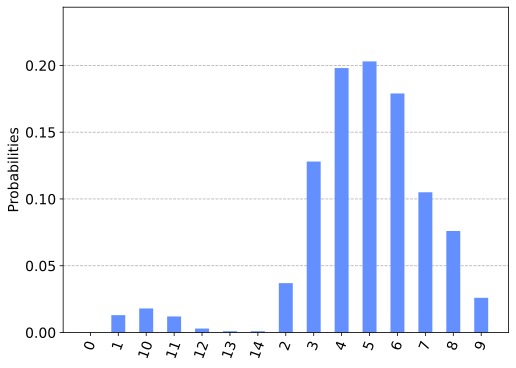

In [19]:
# Evaluate the data from the simulator
counts = result.get_counts()

avr_C       = 0
min_C       = [0, G.number_of_edges()]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G,num_colors)
        
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
        
    # save best bit string
    if( min_C[1] > tmp_eng):
        min_C[0] = sample
        min_C[1] = tmp_eng
                    
M1_sampled   = avr_C/shots   

print('\n --- EXTRA RESULTS ---\n')

max_counts = max(counts, key=lambda key: counts[key])
maximum_coloring = []
list_qubits = max_counts[::-1]

for i in range(len(G)):
    for pos, char in enumerate(list_qubits[i*num_colors:(i*num_colors+num_colors)]):
        if int(char):
            # color = pos
            maximum_coloring.append(pos)

print("\nMax Coloring", maximum_coloring)
print("\nMax Coloring Qudits values")
for i in range(len(G)):
    print(list_qubits[i*num_colors:(i*num_colors+num_colors)])

max_num = [int(num) for num in list(max_counts)]
max_fun   = cost_function_C(max_num,G,num_colors)
print('\nThe approximate solution of max_counts = %s with C(x*) = %d' % (max_counts,max_fun))
print('The number of times this solution showed was: %d' %(counts[max_counts]))


print('\n --- SIMULATION RESULTS ---\n')
#print("Initial Coloring", coloring)

final_coloring = []
list_qubits = min_C[0][::-1]
for i in range(len(G)):
    print(list_qubits[i*num_colors:(i*num_colors+num_colors)])
    for pos, char in enumerate(list_qubits[i*num_colors:(i*num_colors+num_colors)]):
        if int(char):
            # color = pos
            final_coloring.append(pos)

print("\nFinal Coloring",final_coloring)
print("\nFinal Coloring Qudits values")
for i in range(len(G)):
    print(list_qubits[i*num_colors:(i*num_colors+num_colors)])

print('\nThe approximate solution is x* = %s with C(x*) = %d' % (min_C[0],min_C[1]))
print('The number of times this solution showed was: %d \n' %(counts[min_C[0]]))

print('The sampled mean value is Mp_sampled = %.02f' % (M1_sampled))

print('The cost function is distributed as: \n') 
show_figure(plot_histogram(hist,figsize = (8,6),bar_labels = False))

In [ ]:
#backend = provider.get_backend('ibmq_16_melbourne')

qc = QAOA_circ.circuit
print ('Original Circuit')
print('gates = ', qc.count_ops())
print('depth = ', qc.depth())

print('\nOptmization 0')
optimized_0 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=0)
print('gates = ', optimized_0.count_ops())
print('depth = ', optimized_0.depth())

print('\nOptmization 1')
optimized_1 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=1)
print('gates = ', optimized_1.count_ops())
print('depth = ', optimized_1.depth())

print('\nOptmization 2')
optimized_2 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=2)
print('gates = ', optimized_2.count_ops())
print('depth = ', optimized_2.depth())

print('\nOptmization 3')
optimized_3 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=3)
print('gates = ', optimized_3.count_ops())
print('depth = ', optimized_3.depth())

In [ ]:
'''
# QAOA parameters
beta0 = random.uniform(0, np.pi)
gamma = random.uniform(0, 2*np.pi)

# Graph
degree = max(G.degree())
num_colors = 3
#coloring = color_graph(G, num_colors)
coloring = [1 for _ in range(G.number_of_nodes())]

#QAOA_circ = QAOAMaxkColorability(G, num_colors)

#QAOA_circ.initial_state(coloring)
# Mixer 0
#QAOA_circ.mixer(beta0)
#QAOA_circ.phase_separator(gamma)
#QAOA_circ.measurement()
#QAOA_circ.w2_state_generation()

#show_figure(QAOA_circ.circuit.draw())
'''

In [ ]:
qc = QAOA_circ.circuit
print ('Original Circuit')
soma = 0
for i in qc.count_ops():
    soma += qc.count_ops()[i]
print(soma)

optimized_3 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=3)
soma = 0
for i in optimized_3.count_ops():
    soma += optimized_3.count_ops()[i]
print(soma)